# Collision Avoidance Controller Demo

This notebook demonstrates the `CollisionAvoidanceController` which implements COLREGs-compliant collision avoidance with virtual waypoint generation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Polygon
from scipy.integrate import solve_ivp

from colav_controllers import CollisionAvoidanceController

/home/mstolberger/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Controller Parameters

- `a`: Heading dynamics coefficient
- `v`: Ship velocity (m/s)
- `eta`: Controller gain (must be > 1)
- `tp`: Prescribed time for heading convergence (seconds)
- `Cs`: Safe distance from obstacle (m)
- `v1_buffer`: Buffer distance to offset V1 outward for extra clearance (m)

In [2]:
# Controller parameters
a = 1.0       # Heading dynamics coefficient
v = 2.0       # Ship velocity (m/s)
eta = 2.0     # Controller gain (eta > 1)
tp = 3.0      # Prescribed time (seconds)
Cs = 15.0     # Safe distance from obstacle (m)
v1_buffer = 0.0  # V1 buffer (m) - 0 means no buffer

controller = CollisionAvoidanceController(a=a, v=v, eta=eta, tp=tp, Cs=Cs, v1_buffer=v1_buffer)

print(f"Controller initialized")
print(f"Safety radius Cs: {Cs}m")
print(f"V1 buffer: {v1_buffer}m")

Controller initialized
Safety radius Cs: 15.0m
V1 buffer: 0.0m


## Scenario 1: Single Obstacle Avoidance

Ship starts heading toward an obstacle and must avoid it (starboard turn per COLREGs).

In [3]:
# Initial state: [x, y, psi]
x0, y0, psi0 = 0.0, 0.0, np.radians(30)  # Heading 30° (northeast)

# Obstacle position
ox, oy = 40.0, 25.0

print(f"Initial position: ({x0}, {y0})")
print(f"Initial heading: {np.degrees(psi0):.1f}°")
print(f"Obstacle at: ({ox}, {oy})")

Initial position: (0.0, 0.0)
Initial heading: 30.0°
Obstacle at: (40.0, 25.0)


In [4]:
# Set virtual waypoint (V1) based on obstacle
controller.set_virtual_waypoint(x0, y0, psi0, ox, oy)

v1 = controller.virtual_waypoint
print(f"Virtual waypoint V1: ({v1[0]:.2f}, {v1[1]:.2f})")

Virtual waypoint V1: (40.00, 10.00)


In [5]:
# Simulation
t_span = (0, 25)
t_eval = np.linspace(0, 25, 500)

def dynamics(t, state):
    """ODE system for collision avoidance."""
    x, y, psi = state
    return controller.compute_dynamics(t, x, y, psi)

sol = solve_ivp(dynamics, t_span, [x0, y0, psi0], t_eval=t_eval, method='RK45')

print(f"Simulation complete: {len(sol.t)} time steps")

Simulation complete: 500 time steps


## Visualization

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


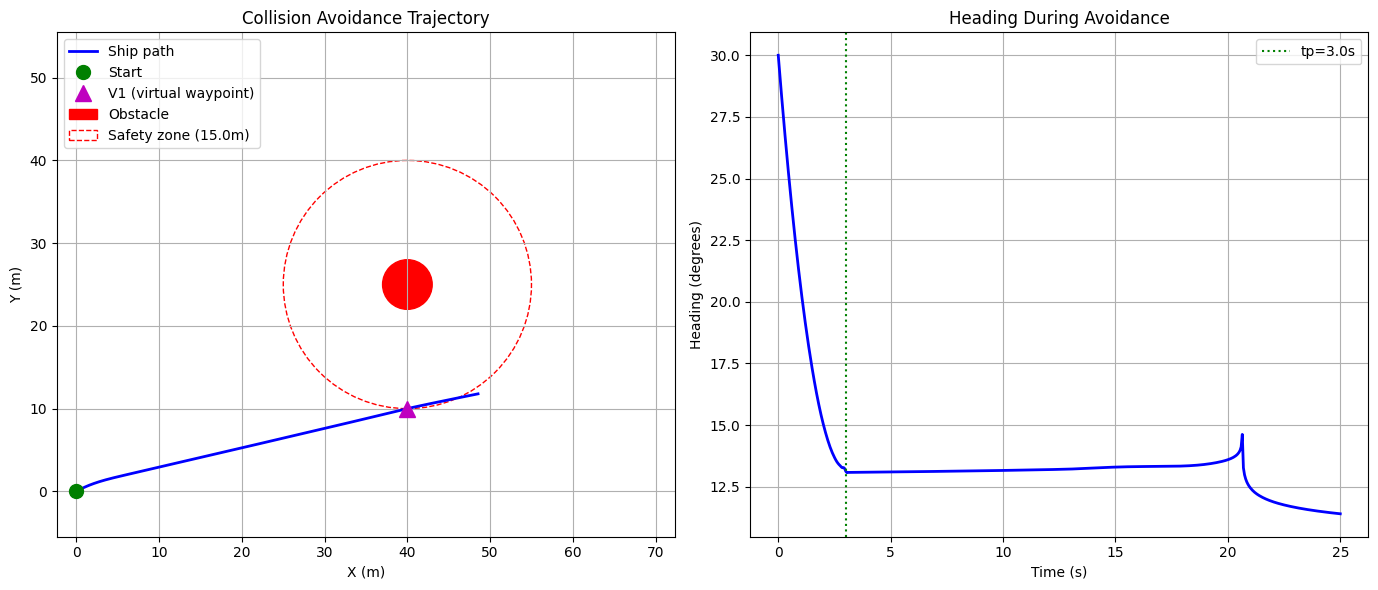

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Trajectory with obstacle
ax = axes[0]
ax.plot(sol.y[0], sol.y[1], 'b-', linewidth=2, label='Ship path')
ax.plot(x0, y0, 'go', markersize=10, label='Start')
ax.plot(v1[0], v1[1], 'm^', markersize=12, label='V1 (virtual waypoint)')

# Draw obstacle and safety zone
obstacle = Circle((ox, oy), 3, color='red', label='Obstacle')
safety_zone = Circle((ox, oy), Cs, color='red', fill=False, linestyle='--', label=f'Safety zone ({Cs}m)')
ax.add_patch(obstacle)
ax.add_patch(safety_zone)

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Collision Avoidance Trajectory')
ax.legend(loc='upper left')
ax.grid(True)
ax.axis('equal')
ax.set_xlim(-10, 80)
ax.set_ylim(-10, 60)

# Plot 2: Heading over time
ax = axes[1]
psi_deg = np.degrees(sol.y[2])
ax.plot(sol.t, psi_deg, 'b-', linewidth=2)
ax.axvline(x=tp, color='g', linestyle=':', label=f'tp={tp}s')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Heading (degrees)')
ax.set_title('Heading During Avoidance')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

## Verify Collision Avoidance

Check minimum distance to obstacle during maneuver.

In [7]:
# Calculate distance to obstacle over time
distances = np.sqrt((sol.y[0] - ox)**2 + (sol.y[1] - oy)**2)
min_distance = np.min(distances)
min_idx = np.argmin(distances)

print(f"Minimum distance to obstacle: {min_distance:.2f}m")
print(f"Safety margin Cs: {Cs}m")
print(f"Collision avoided: {min_distance >= Cs}")
print(f"Closest approach at t = {sol.t[min_idx]:.2f}s")

Minimum distance to obstacle: 14.66m
Safety margin Cs: 15.0m
Collision avoided: False
Closest approach at t = 22.19s


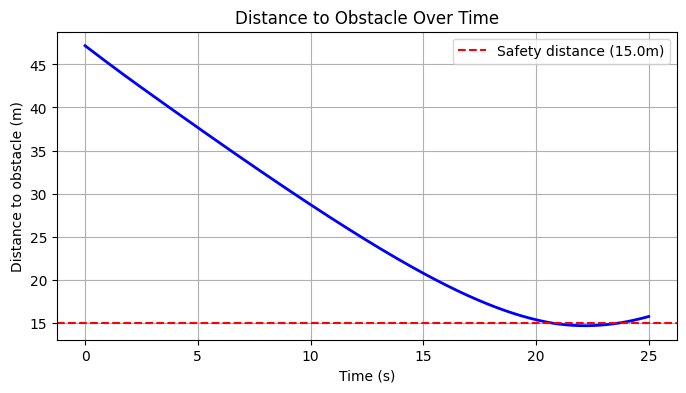

In [8]:
# Plot distance over time
plt.figure(figsize=(8, 4))
plt.plot(sol.t, distances, 'b-', linewidth=2)
plt.axhline(y=Cs, color='r', linestyle='--', label=f'Safety distance ({Cs}m)')
plt.xlabel('Time (s)')
plt.ylabel('Distance to obstacle (m)')
plt.title('Distance to Obstacle Over Time')
plt.legend()
plt.grid(True)
plt.show()

## Scenario 2: Multiple Obstacles (Dynamic Mode)

In [9]:
# Reset controller
controller.reset()

# Multiple obstacles: (x, y, velocity, heading)
obstacles = [
    (30.0, 15.0, 0.0, 0.0),
    (50.0, 35.0, 0.0, 0.0),
]

# Set virtual waypoint for multiple obstacles
x0_2, y0_2, psi0_2 = 0.0, 0.0, np.radians(25)
controller.set_virtual_waypoint_dynamic(x0_2, y0_2, psi0_2, obstacles)

v1_multi = controller.virtual_waypoint
print(f"Virtual waypoint V1: ({v1_multi[0]:.2f}, {v1_multi[1]:.2f})")

Virtual waypoint V1: (30.00, 0.00)


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


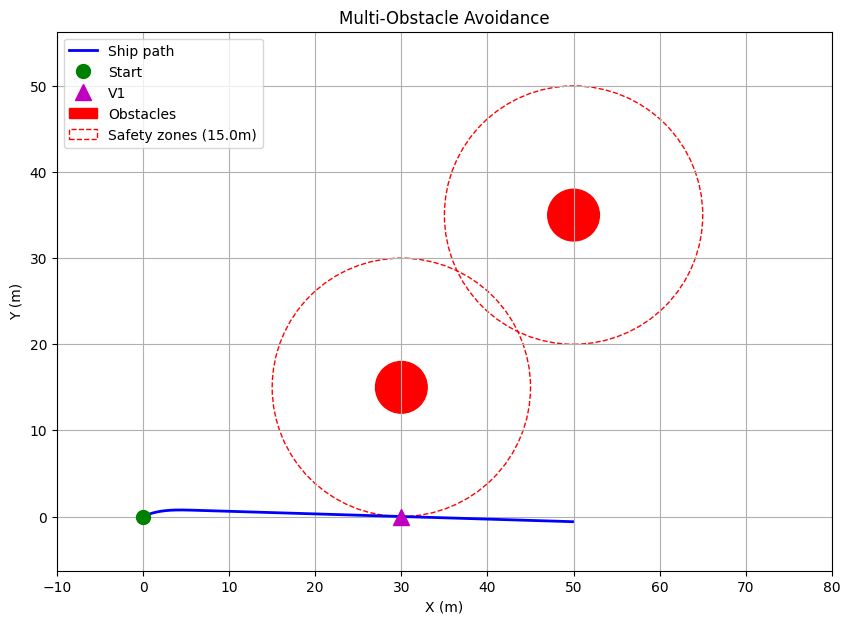

In [10]:
# Simulate
sol2 = solve_ivp(dynamics, t_span, [x0_2, y0_2, psi0_2], t_eval=t_eval, method='RK45')

# Visualize
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(sol2.y[0], sol2.y[1], 'b-', linewidth=2, label='Ship path')
ax.plot(x0_2, y0_2, 'go', markersize=10, label='Start')
ax.plot(v1_multi[0], v1_multi[1], 'm^', markersize=12, label='V1')

# Draw obstacles
for i, (ox_i, oy_i, _, _) in enumerate(obstacles):
    obstacle = Circle((ox_i, oy_i), 3, color='red')
    safety_zone = Circle((ox_i, oy_i), Cs, color='red', fill=False, linestyle='--')
    ax.add_patch(obstacle)
    ax.add_patch(safety_zone)
    if i == 0:
        obstacle.set_label('Obstacles')
        safety_zone.set_label(f'Safety zones ({Cs}m)')

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Multi-Obstacle Avoidance')
ax.legend()
ax.grid(True)
ax.axis('equal')
ax.set_xlim(-10, 80)
ax.set_ylim(-10, 60)

plt.show()

## Scenario 3: Using V1 Buffer

Demonstrate the `v1_buffer` parameter which offsets V1 outward for extra clearance.

In [11]:
# Create controller with buffer
controller_buffered = CollisionAvoidanceController(
    a=a, v=v, eta=eta, tp=tp, Cs=Cs, 
    v1_buffer=5.0  # 5 meter buffer
)

# Same initial conditions as Scenario 1
x0_3, y0_3, psi0_3 = 0.0, 0.0, np.radians(30)
ox_3, oy_3 = 40.0, 25.0

# Compute V1 without buffer
controller.reset()
controller.set_virtual_waypoint(x0_3, y0_3, psi0_3, ox_3, oy_3)
v1_no_buffer = controller.virtual_waypoint

# Compute V1 with buffer
controller_buffered.set_virtual_waypoint(x0_3, y0_3, psi0_3, ox_3, oy_3)
v1_with_buffer = controller_buffered.virtual_waypoint

print(f"V1 without buffer: ({v1_no_buffer[0]:.2f}, {v1_no_buffer[1]:.2f})")
print(f"V1 with 5m buffer: ({v1_with_buffer[0]:.2f}, {v1_with_buffer[1]:.2f})")

V1 without buffer: (40.00, 10.00)
V1 with 5m buffer: (40.00, 5.00)


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


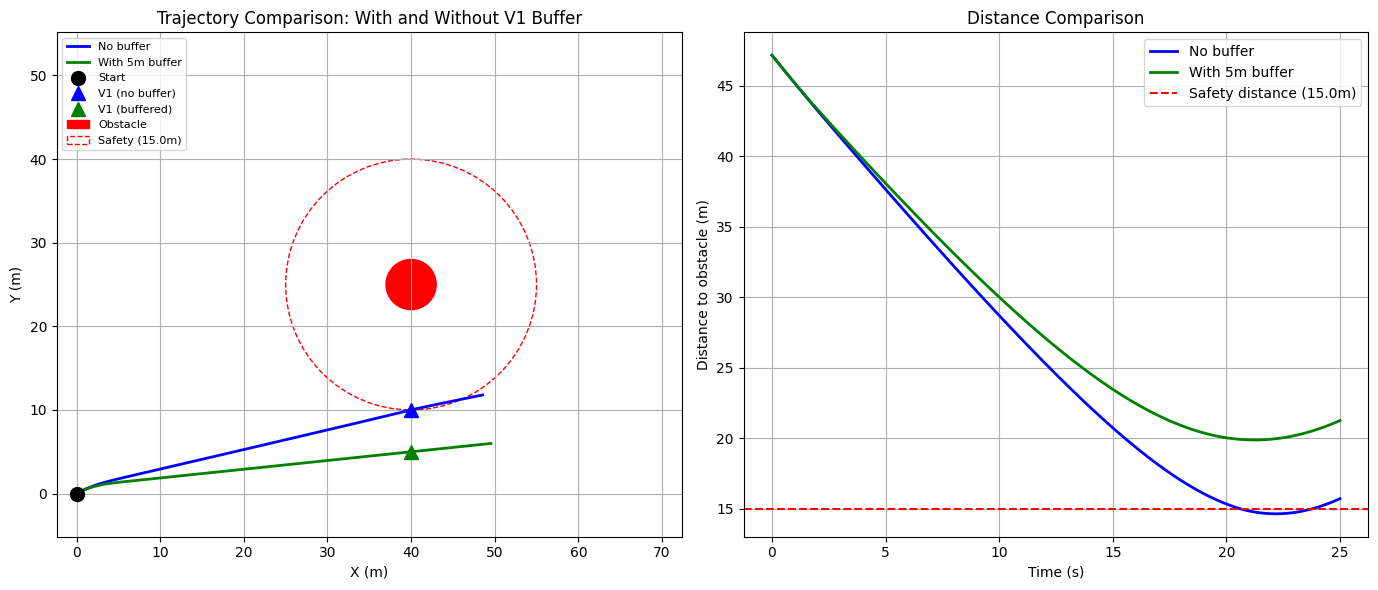

Min distance (no buffer): 14.66m
Min distance (with buffer): 19.89m
Extra clearance: 5.23m


In [12]:
# Simulate both trajectories
def dynamics_buffered(t, state):
    x, y, psi = state
    return controller_buffered.compute_dynamics(t, x, y, psi)

sol_no_buffer = solve_ivp(dynamics, t_span, [x0_3, y0_3, psi0_3], t_eval=t_eval, method='RK45')
sol_with_buffer = solve_ivp(dynamics_buffered, t_span, [x0_3, y0_3, psi0_3], t_eval=t_eval, method='RK45')

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Trajectories
ax = axes[0]
ax.plot(sol_no_buffer.y[0], sol_no_buffer.y[1], 'b-', linewidth=2, label='No buffer')
ax.plot(sol_with_buffer.y[0], sol_with_buffer.y[1], 'g-', linewidth=2, label='With 5m buffer')
ax.plot(x0_3, y0_3, 'ko', markersize=10, label='Start')
ax.plot(v1_no_buffer[0], v1_no_buffer[1], 'b^', markersize=10, label='V1 (no buffer)')
ax.plot(v1_with_buffer[0], v1_with_buffer[1], 'g^', markersize=10, label='V1 (buffered)')

# Draw obstacle
obstacle = Circle((ox_3, oy_3), 3, color='red', label='Obstacle')
safety_zone = Circle((ox_3, oy_3), Cs, color='red', fill=False, linestyle='--', label=f'Safety ({Cs}m)')
ax.add_patch(obstacle)
ax.add_patch(safety_zone)

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Trajectory Comparison: With and Without V1 Buffer')
ax.legend(loc='upper left', fontsize=8)
ax.grid(True)
ax.axis('equal')
ax.set_xlim(-10, 80)
ax.set_ylim(-10, 60)

# Plot 2: Distance comparison
ax = axes[1]
dist_no_buffer = np.sqrt((sol_no_buffer.y[0] - ox_3)**2 + (sol_no_buffer.y[1] - oy_3)**2)
dist_with_buffer = np.sqrt((sol_with_buffer.y[0] - ox_3)**2 + (sol_with_buffer.y[1] - oy_3)**2)

ax.plot(sol_no_buffer.t, dist_no_buffer, 'b-', linewidth=2, label='No buffer')
ax.plot(sol_with_buffer.t, dist_with_buffer, 'g-', linewidth=2, label='With 5m buffer')
ax.axhline(y=Cs, color='r', linestyle='--', label=f'Safety distance ({Cs}m)')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Distance to obstacle (m)')
ax.set_title('Distance Comparison')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

print(f"Min distance (no buffer): {np.min(dist_no_buffer):.2f}m")
print(f"Min distance (with buffer): {np.min(dist_with_buffer):.2f}m")
print(f"Extra clearance: {np.min(dist_with_buffer) - np.min(dist_no_buffer):.2f}m")

## Custom Vertex Provider

Demonstrate using a custom vertex provider for different unsafe set shapes.

In [13]:
def square_vertex_provider(pos_x, pos_y, obstacles_list, Cs, psi):
    """
    Custom vertex provider that creates square unsafe sets.
    
    Args:
        pos_x, pos_y: Ship position
        obstacles_list: List of (ox, oy, ov, o_psi) tuples
        Cs: Safety distance
        psi: Ship heading
    
    Returns:
        List of vertices forming square unsafe sets
    """
    if not obstacles_list:
        return None
    
    vertices = []
    for ox, oy, _, _ in obstacles_list:
        # Create square vertices
        vertices.extend([
            (ox + Cs, oy + Cs),   # Top right
            (ox - Cs, oy + Cs),   # Top left
            (ox - Cs, oy - Cs),   # Bottom left
            (ox + Cs, oy - Cs),   # Bottom right
        ])
    
    return vertices if vertices else None

# Create controller with custom vertex provider
controller_custom = CollisionAvoidanceController(
    a=a, v=v, eta=eta, tp=tp, Cs=Cs,
    vertex_provider=square_vertex_provider
)

print("Controller with square vertex provider created")

Controller with square vertex provider created


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


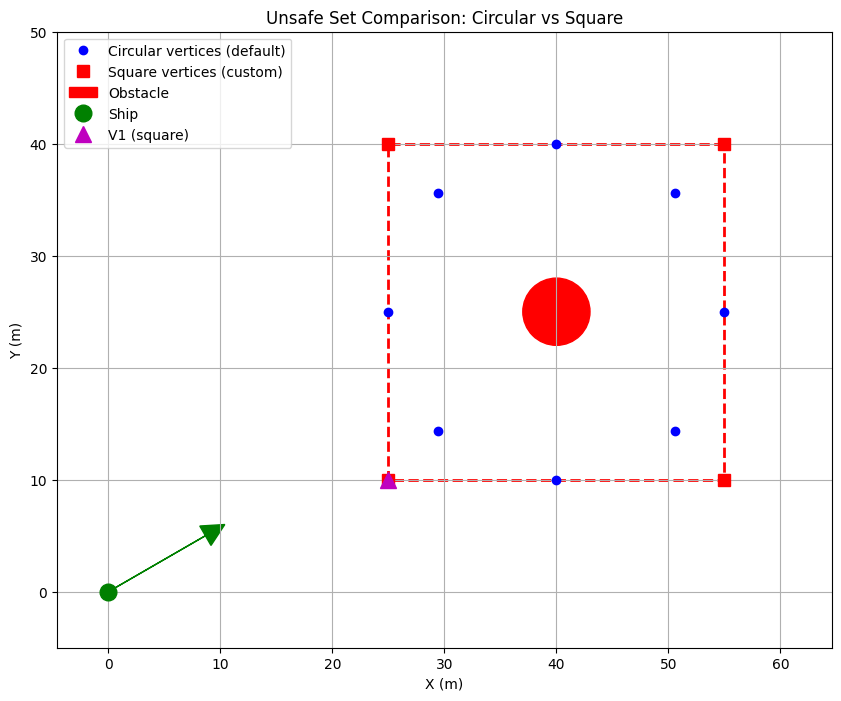

In [14]:
# Test with single obstacle
x0_4, y0_4, psi0_4 = 0.0, 0.0, np.radians(30)
ox_4, oy_4 = 40.0, 25.0

controller_custom.set_virtual_waypoint(x0_4, y0_4, psi0_4, ox_4, oy_4)
v1_custom = controller_custom.virtual_waypoint

# Get vertices for visualization
obstacles_4 = [(ox_4, oy_4, 0.0, 0.0)]
vertices_circular = controller.vertex_provider(x0_4, y0_4, obstacles_4, Cs, psi0_4)
vertices_square = square_vertex_provider(x0_4, y0_4, obstacles_4, Cs, psi0_4)

# Visualize unsafe sets
fig, ax = plt.subplots(figsize=(10, 8))

# Draw circular unsafe set vertices
if vertices_circular:
    vx, vy = zip(*vertices_circular)
    ax.plot(vx, vy, 'bo', markersize=6, label='Circular vertices (default)')

# Draw square unsafe set vertices
if vertices_square:
    vx_sq, vy_sq = zip(*vertices_square)
    ax.plot(vx_sq, vy_sq, 'rs', markersize=8, label='Square vertices (custom)')
    # Draw square polygon
    square_poly = Polygon(vertices_square, fill=False, edgecolor='red', linewidth=2, linestyle='--')
    ax.add_patch(square_poly)

# Draw obstacle
obstacle = Circle((ox_4, oy_4), 3, color='red', label='Obstacle')
ax.add_patch(obstacle)

# Draw ship position and heading
ax.plot(x0_4, y0_4, 'go', markersize=12, label='Ship')
ax.arrow(x0_4, y0_4, 10*np.cos(psi0_4), 10*np.sin(psi0_4), 
         head_width=2, head_length=2, fc='green', ec='green')

ax.plot(v1_custom[0], v1_custom[1], 'm^', markersize=12, label='V1 (square)')

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Unsafe Set Comparison: Circular vs Square')
ax.legend()
ax.grid(True)
ax.axis('equal')
ax.set_xlim(-5, 65)
ax.set_ylim(-5, 50)

plt.show()

## Scenario 4: Constant Heading Mode

After avoidance, the ship can maintain constant heading using `compute_constant_dynamics()`.

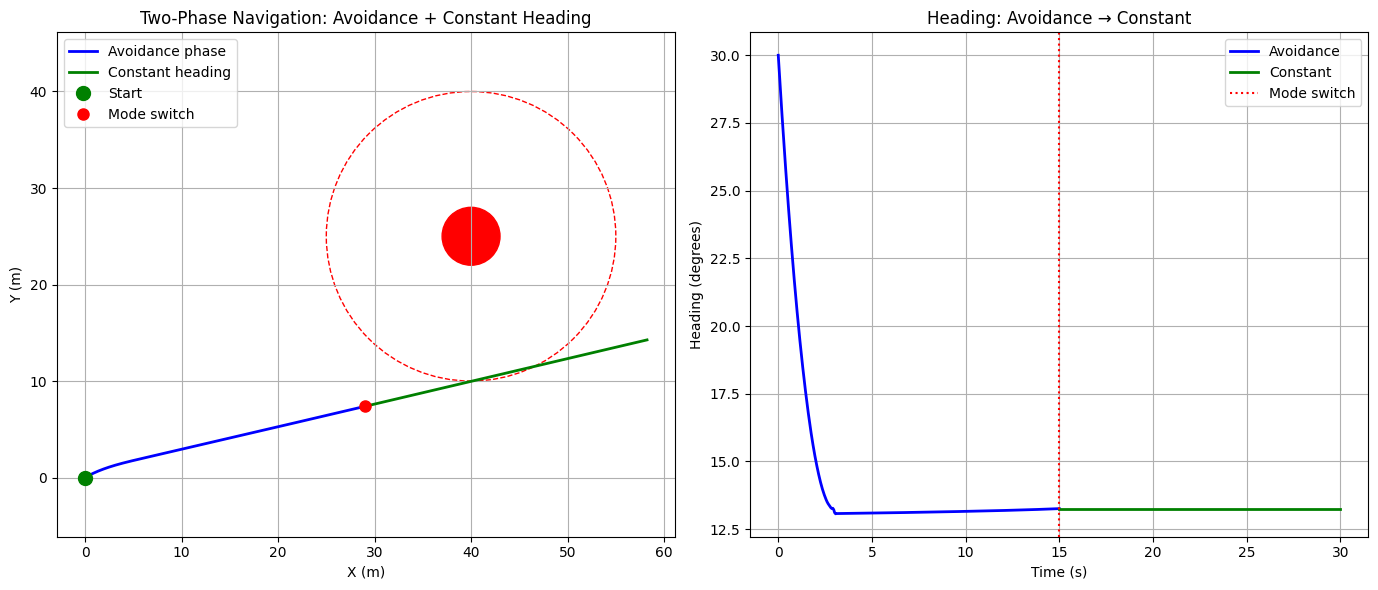

Final heading: 13.26°
Heading variation in constant mode: 0.0000°


In [15]:
# First: avoid obstacle (use result from Scenario 1)
# Then: switch to constant heading mode

# Reset and set up
controller.reset()
controller.set_virtual_waypoint(0.0, 0.0, np.radians(30), 40.0, 25.0)

# Phase 1: Avoidance (0 to 15s)
t_avoid = (0, 15)
sol_avoid = solve_ivp(dynamics, t_avoid, [0.0, 0.0, np.radians(30)], 
                      t_eval=np.linspace(0, 15, 300), method='RK45')

# Phase 2: Constant heading (15 to 30s)
final_state = sol_avoid.y[:, -1]

def dynamics_constant(t, state):
    x, y, psi = state
    return controller.compute_constant_dynamics(x, y, psi)

t_constant = (0, 15)
sol_constant = solve_ivp(dynamics_constant, t_constant, final_state,
                         t_eval=np.linspace(0, 15, 300), method='RK45')

# Combine trajectories
combined_x = np.concatenate([sol_avoid.y[0], sol_constant.y[0]])
combined_y = np.concatenate([sol_avoid.y[1], sol_constant.y[1]])
combined_psi = np.concatenate([sol_avoid.y[2], sol_constant.y[2]])
combined_t = np.concatenate([sol_avoid.t, sol_constant.t + 15])

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Trajectory
ax = axes[0]
ax.plot(combined_x[:300], combined_y[:300], 'b-', linewidth=2, label='Avoidance phase')
ax.plot(combined_x[300:], combined_y[300:], 'g-', linewidth=2, label='Constant heading')
ax.plot(0, 0, 'go', markersize=10, label='Start')
ax.plot(combined_x[299], combined_y[299], 'ro', markersize=8, label='Mode switch')

obstacle = Circle((40.0, 25.0), 3, color='red')
safety_zone = Circle((40.0, 25.0), Cs, color='red', fill=False, linestyle='--')
ax.add_patch(obstacle)
ax.add_patch(safety_zone)

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Two-Phase Navigation: Avoidance + Constant Heading')
ax.legend()
ax.grid(True)
ax.axis('equal')

# Heading
ax = axes[1]
ax.plot(combined_t[:300], np.degrees(combined_psi[:300]), 'b-', linewidth=2, label='Avoidance')
ax.plot(combined_t[300:], np.degrees(combined_psi[300:]), 'g-', linewidth=2, label='Constant')
ax.axvline(x=15, color='r', linestyle=':', label='Mode switch')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Heading (degrees)')
ax.set_title('Heading: Avoidance → Constant')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

print(f"Final heading: {np.degrees(combined_psi[-1]):.2f}°")
print(f"Heading variation in constant mode: {np.std(np.degrees(combined_psi[300:])):.4f}°")